# IPWC Bug

@roman_avj
1 Nov 23

Look how to fix the $\hat{G}(t_{n}) == 0$

In [3]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from sklearn.pipeline import Pipeline, make_pipeline
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis, IPCRidge
from sksurv.ensemble import RandomSurvivalForest, ExtraSurvivalTrees, GradientBoostingSurvivalAnalysis
from scipy.integrate import simpson

TYPE_INFO = 'ALL_DATA'

# Data

## Preprocessing

In [4]:
# read
df_model = pd.read_parquet('../../data/data2analyze_clean_v2_rent.parquet')
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26541 entries, 0 to 26540
Columns: 141 entries, id to cosine_tmonth
dtypes: datetime64[us](2), float64(122), int32(1), int64(4), object(9), string(3)
memory usage: 28.5+ MB


In [5]:
# add if has maintenance
df_model['has_maintenance'] = df_model['cost_of_maintenance'].apply(lambda x: 1 if x > 0 else 0)

In [6]:
# clip columns with 'lag' up to 99 percentile
vars_lag = df_model.columns[df_model.columns.str.contains('lag')]
df_model[vars_lag] = df_model[vars_lag].clip(upper=df_model[vars_lag].quantile(0.99), axis=1)

### Create Synthetic Variable

In [7]:
# look rows with maximum time2event
df_max = df_model[df_model['time2event'] == df_model['time2event'].max()]
df_max

,id,marketplace,first_observed_date,last_observed_date,count_repeated,time2event,event,id_sepomex,listing_type,property_type,...,bin_group_marketplace,woe_marketplace,bin_group_seller,woe_seller,bin_group_id_sepomex,woe_id_sepomex,diff_first_prediction,sine_tmonth,cosine_tmonth,has_maintenance
1048,49af96c340647cb6d5f75c6f3262932c,inmuebles24,2023-03-26 01:20:13,2023-07-25 04:56:52,2,121.0,1,11629,for-rent,apartment,...,group_3,0.235393,group_2,0.065077,group_3,1.282975,0.202517,1.000000e+00,6.123234e-17,0
1230,191020db12d230bbe988db301beabbf4,inmuebles24,2023-06-17 01:31:28,2023-10-09 19:48:39,1,121.0,0,11779,for-rent,apartment,...,group_3,0.235393,group_2,0.065077,group_2,0.175340,-0.441785,1.224647e-16,-1.000000e+00,0
4043,47685c3c48d8cad2f2be1aa15cf657fb,inmuebles24,2023-06-03 05:22:22,2023-10-02 20:03:47,11,121.0,1,11752,for-rent,apartment,...,group_3,0.235393,group_2,0.065077,group_1,-0.277533,0.117295,1.224647e-16,-1.000000e+00,0
6727,0487e3c66cc2b86292ff89a6bec950d8,inmuebles24,2023-06-17 01:11:40,2023-10-09 19:48:36,2,121.0,0,11143,for-rent,apartment,...,group_3,0.235393,group_2,0.065077,group_1,-0.277533,-0.026623,1.224647e-16,-1.000000e+00,0
7926,40ac91d12de60e74dd3a12b263e0f9b4,inmuebles24,2023-03-12 02:19:51,2023-07-11 03:05:28,3,121.0,1,12756,for-rent,apartment,...,group_3,0.235393,group_2,0.065077,group_0,-0.740097,-0.209105,1.000000e+00,6.123234e-17,0
8022,4691ee468b0aa4ece5c2c5e928fcf85e,easybroker,2023-06-17 11:47:39,2023-10-16 18:24:21,2,121.0,0,12687,for-rent,house,...,group_0,-0.397016,group_2,0.065077,group_1,-0.277533,0.034263,1.224647e-16,-1.000000e+00,0
8522,5456808b253e7c1a9ab5ebbb30a8da10,inmuebles24,2023-06-16 19:26:50,2023-10-09 20:09:28,1,121.0,0,12727,for-rent,house,...,group_3,0.235393,group_2,0.065077,group_2,0.175340,0.000872,1.224647e-16,-1.000000e+00,0
8929,9dc42b1319d4d33455fad8c1386da8af,inmuebles24,2023-04-23 00:42:26,2023-08-22 05:40:35,4,121.0,1,11498,for-rent,apartment,...,group_3,0.235393,group_3,1.810651,group_2,0.175340,-0.000946,8.660254e-01,-5.000000e-01,0
11515,5d1cb7c57a7fd60c5106aa7b56feb5d6,metros_cubicos,2023-03-19 05:33:47,2023-07-18 06:09:00,3,121.0,1,11534,for-rent,apartment,...,group_2,0.025046,group_2,0.065077,group_2,0.175340,0.122776,1.000000e+00,6.123234e-17,0
11705,43f8a9bffec7f4ac0700ef4cd3bc6224,metros_cubicos,2023-04-23 06:15:33,2023-08-23 04:57:36,5,121.0,1,11547,for-rent,apartment,...,group_2,0.025046,group_2,0.065077,group_2,0.175340,0.453131,8.660254e-01,-5.000000e-01,0


In [8]:
# get a random id from df_max, first trye for event == 1, then for event == 0
id_max = df_max[df_max['event'] == 1]['id'].sample(1, random_state=8).values[0]
if pd.isna(id_max):
    id_max = df_max[df_max['event'] == 0]['id'].sample(1, random_state=8).values[0]

In [9]:
# look at the data for id_max
df_model[df_model['id'] == id_max][['time2event', 'event']]

,time2event,event
23511,121.0,1


In [10]:
# for id_max add 1 to time2event and set event = 1
df_model.loc[df_model['id'] == id_max, 'time2event'] =\
     df_model.loc[df_model['id'] == id_max, 'time2event'] + 1

df_model.loc[df_model['id'] == id_max, 'event'] = 1

### Selection

In [11]:
# select columns
vars_x_categorical = ['listing_type', 'property_type']
vars_x_discrete = ['num_bathrooms', 'num_parking_lots']
vars_x_woe = ['woe_marketplace', 'woe_seller', 'woe_id_sepomex']
vars_x_numerical = [
    'first_price', 'diff_first_prediction', 
    'prediction_price_per_square_meter',
    'surface_total', 'page_on_marketplace',
    'is_new_property_prob', 'total_cost_of_living', 'green_index', 'days_active',
    'relative_cost_of_living'
    ]
vars_x_binary = ['is_exterior', 'pets_allowed', 'has_maintenance']
vars_x_geographic = ['latitude', 'longitude']
vars_x_time = ['sine_tmonth', 'cosine_tmonth']

vars_x_names = vars_x_categorical + vars_x_numerical + vars_x_binary + vars_x_discrete + vars_x_geographic + vars_x_time + vars_x_woe

# corroborate there are not duplicates in the vars_x_names
print(len(vars_x_names))
print(len(set(vars_x_names)))

24
24


### Train & Test

In [12]:
# get y data as sksurv need
data_y = np.array(
    list(zip(df_model['event'], df_model['time2event'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

# get x data
data_x = (
    df_model.copy()
    .assign(prediction_price=lambda x: x['first_price'].div(1e+6))
    .astype({col: 'category' for col in vars_x_categorical})
    .astype({col: np.float64 for col in vars_x_numerical})
    .astype({col: np.int8 for col in vars_x_binary})
    [vars_x_names]
)
data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26541 entries, 0 to 26540
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   listing_type                       26541 non-null  category
 1   property_type                      26541 non-null  category
 2   first_price                        26541 non-null  float64 
 3   diff_first_prediction              26541 non-null  float64 
 4   prediction_price_per_square_meter  26541 non-null  float64 
 5   surface_total                      26541 non-null  float64 
 6   page_on_marketplace                26541 non-null  float64 
 7   is_new_property_prob               26541 non-null  float64 
 8   total_cost_of_living               26541 non-null  float64 
 9   green_index                        26541 non-null  float64 
 10  days_active                        26541 non-null  float64 
 11  relative_cost_of_living            26541 

In [13]:
# one hot encoding #
data_x_numeric = OneHotEncoder().fit_transform(data_x)
colnames_x_numeric = data_x_numeric.columns

# boxcox (yeo-johnson) transformation BY property type #
def boxcox(X):
    # power_transform
    power_transform = PowerTransformer(method='yeo-johnson', standardize=True).fit(X)
    X_transf = power_transform.transform(X)
    return X_transf, power_transform

# get boxcox transformation for each property type
boxcox_vars_property = [
    'first_price', 'prediction_price_per_square_meter', 'surface_total', 'is_new_property_prob'
]
# difference between vars_x_numerical and boxcox_vars_property
boxcox_vars_all = list(set(vars_x_numerical) - set(boxcox_vars_property))
# box cox transformation by property type #
# subset data
idx_house = (data_x_numeric['property_type=house'] >= 1)
idx_apartment = (data_x_numeric['property_type=house'] < 1)

# get boxcox transformation
data_x_numeric.loc[idx_house, boxcox_vars_property], pt_house = boxcox(data_x_numeric.loc[idx_house, boxcox_vars_property])
data_x_numeric.loc[idx_apartment, boxcox_vars_property], pt_apartment = boxcox(data_x_numeric.loc[idx_apartment, boxcox_vars_property])
data_x_numeric[boxcox_vars_all], pt_all = boxcox(data_x_numeric[boxcox_vars_all])

# scale #
# scale
def scale(X):
    # power_transform
    standard_scaler = StandardScaler().fit(X)
    X_transf = standard_scaler.transform(X)
    return X_transf, standard_scaler

# get scaler transformation for each property type
standard_vars = vars_x_discrete
# scaler transformation by property type #
# subset data
idx_house = (data_x_numeric['property_type=house'] >= 1)
idx_apartment = (data_x_numeric['property_type=house'] < 1)

# get scaler transformation
data_x_numeric.loc[idx_house, standard_vars], st_house = scale(data_x_numeric.loc[idx_house, standard_vars])
data_x_numeric.loc[idx_apartment, standard_vars], st_apartment = scale(data_x_numeric.loc[idx_apartment, standard_vars])
# to numeric
data_x_numeric = data_x_numeric.to_numpy()


dropped categorical variable 'listing_type', because it has only 1 values


In [14]:
# to numeric
pd.DataFrame(data_x_numeric, columns=colnames_x_numeric).head(3)

,property_type=house,first_price,diff_first_prediction,prediction_price_per_square_meter,surface_total,page_on_marketplace,is_new_property_prob,total_cost_of_living,green_index,days_active,...,has_maintenance,num_bathrooms,num_parking_lots,latitude,longitude,sine_tmonth,cosine_tmonth,woe_marketplace,woe_seller,woe_id_sepomex
0,0.0,-1.449619,-0.747566,-1.290174,-0.613845,-0.348624,-0.544545,-0.572298,-1.048412,-1.296468,...,0.0,0.310737,-0.768490,19.478474,-99.210293,1.224647e-16,-1.000000,0.025046,0.065077,0.17534
1,0.0,-1.586037,-1.030759,-0.932039,-0.964186,-1.038756,-0.158285,1.141924,-1.048412,-1.296468,...,0.0,-1.097058,-0.170226,19.478672,-99.206866,1.224647e-16,-1.000000,0.235393,0.065077,0.17534
2,0.0,-1.847394,-1.738722,-1.486820,-0.578656,0.492888,-0.673979,-0.776076,-1.048412,-1.296468,...,0.0,-1.097058,0.128907,19.479462,-99.207931,-5.000000e-01,-0.866025,-0.113731,0.065077,0.17534


#### Get in train the maximum observed time

In [15]:
# get the row with id_max
data_x_max = data_x_numeric[df_model['id'] == id_max]
idx_delete = df_model[df_model['id'] == id_max].index
data_x_max

array([[ 1.00000000e+00, -8.68050287e-01,  8.92679886e-01,
        -5.89516148e-01, -1.32364319e+00, -1.03875636e+00,
        -1.66789942e-02,  9.02466756e-01,  4.88605886e-01,
         8.58983115e-01, -5.19650983e-01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.55541922e-01,
        -4.53727283e-01,  1.95222140e+01, -9.91476360e+01,
         5.00000000e-01, -8.66025404e-01,  2.35393029e-01,
         6.50769960e-02,  1.75339938e-01]])

In [16]:
# delete row_id_max from data_x_numeric
data_x_numeric = np.delete(data_x_numeric, idx_delete, axis=0)

# also delete from data_y
data_y_max = data_y[idx_delete]
data_y = np.delete(data_y, idx_delete, axis=0)

In [19]:
# split train & test
X_train, X_test, y_train, y_test = train_test_split(
    data_x_numeric, data_y, test_size=0.1, random_state=42
)

In [20]:
# add id_max to X_train & y_train
X_train = np.vstack([X_train, data_x_max])
y_train = np.hstack([y_train, data_y_max])

# Modelo V0: avg

## Fit

In [21]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin

class AvgModel(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.global_mean = None
        self.group_means = None
    
    def fit(self, X, y):
        # Create a DataFrame from the structured array y
        y_df = pd.DataFrame({'Status': y['Status'], 'Survival_in_days': y['Survival_in_days']})
        
        # Merge X and y 
        merged_data = pd.concat([X, y_df], axis=1)

        # Filter out observations without an event
        merged_data = merged_data[merged_data['Status'] >= 1]
        
        # Group the data by X1, X2, ..., Xp values and compute the average Survival_in_days for each group
        self.group_means = merged_data.groupby(list(X.columns))['Survival_in_days'].mean().reset_index()
        
        # Compute the global average of Survival_in_days
        self.global_mean = y_df.query("Status >= 1")['Survival_in_days'].mean()
    
    def predict(self, X):
        # Merge the test data (X) with the group means on X1, X2, ..., Xp values
        merged_data = X.merge(self.group_means, on=list(X.columns), how='left')
        
        # Fill missing group means with the global mean
        merged_data['Survival_in_days'].fillna(self.global_mean, inplace=True)
        
        return merged_data['Survival_in_days'].values

In [22]:
# get x data
df_x = df_model.copy()[['listing_type', 'property_type', 'id_sepomex_raw', 'event']]
y_val = np.array(
    list(zip(df_model['event'], df_model['time2event'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

# split train & test
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    df_x, y_val, test_size=0.2, random_state=42
)

In [23]:
# train 
basemode = AvgModel()
basemode.fit(X_train_base, y_train_base)

## Train

In [49]:
def get_observed(X, y):
    # get observed time
    yobs = y[y['Status']]['Survival_in_days']

    # get observed rows
    Xobs = X[y['Status']]

    return Xobs, yobs

# predict
# predict mean time
Xobs, yobs = get_observed(X_train_base, y_train_base)
mean_time = basemode.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 26.122
MAPE: 0.943


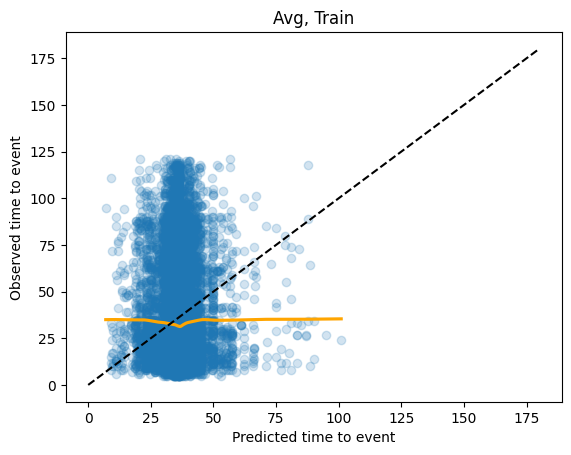

In [50]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('Avg, Train')
plt.show()

## Test

### General

In [51]:
# predict
# predict mean time
Xobs, yobs = get_observed(X_test_base, y_test_base)
mean_time = basemode.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 26.318
MAPE: 0.925


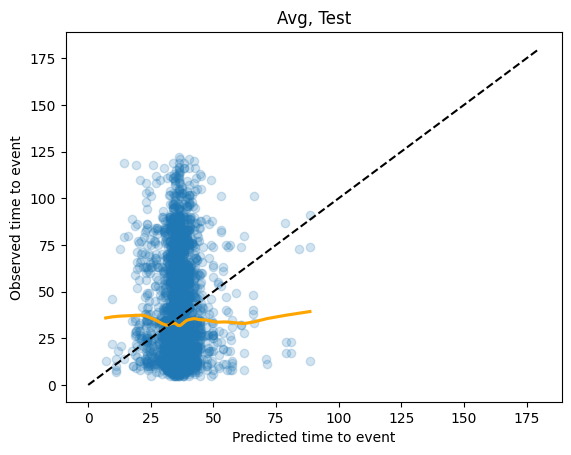

In [52]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('Avg, Test')
plt.show()

### Particular

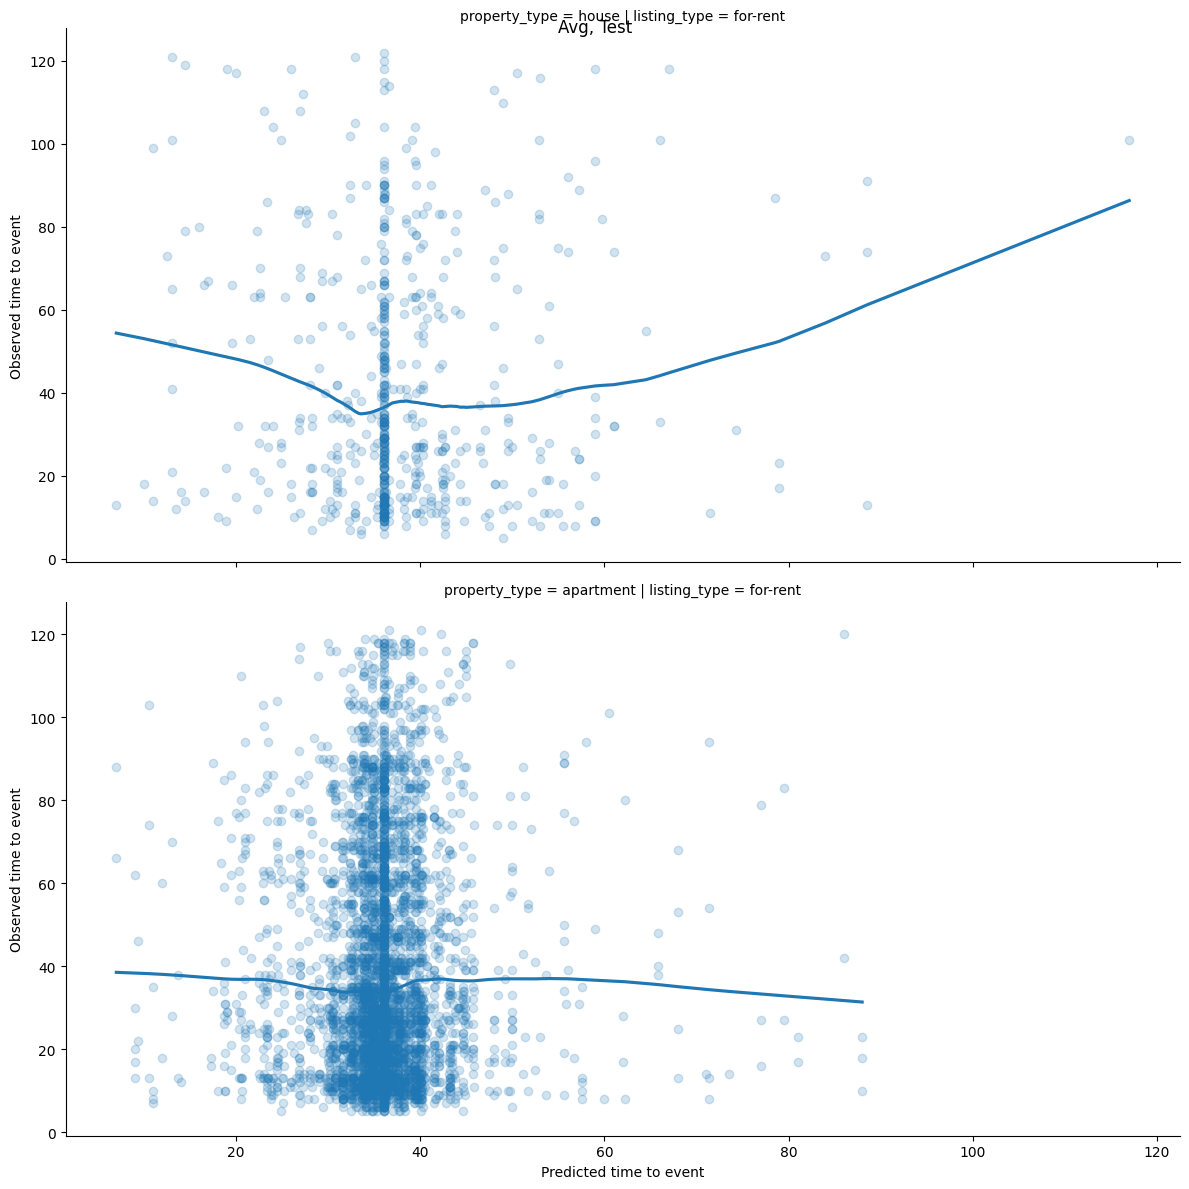

In [53]:
# get df of predictions and observed
df_pred = (
    X_test_base.copy()
    .assign(
        predicted_time=basemode.predict(X_test_base),
        risk_score=lambda x: - x['predicted_time'],
        observed_time=y_test_base['Survival_in_days'],
        event=y_test_base['Status']
    )
)

# plot a regplot observed vs predicted, facet grid listing_type and property_type

g = sns.FacetGrid(df_pred, col='listing_type', row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('Avg, Test')
plt.show()

In [54]:
# get rmse and mape by listing_type and property_type
def get_metrics(df):
    df = df.copy()
    cindex = concordance_index_censored(df['event'], df['observed_time'], df['risk_score'])[0]
    # rmse & mape for all with event as True
    rmse = np.sqrt(np.mean((df[df['event']]['predicted_time'] - df[df['event']]['observed_time'])**2))
    mape = np.mean(np.abs((df[df['event']]['predicted_time'] - df[df['event']]['observed_time']) / df[df['event']]['observed_time']))
    return pd.Series({'rmse': rmse, 'mape': mape, 'cindex': cindex})

# get all
table_pred = (
    df_pred
    .groupby(['listing_type', 'property_type'])
    .apply(get_metrics)
    .assign(type_info=TYPE_INFO)
)

# save
os.makedirs('../../results/vanillas/', exist_ok=True)
table_pred.to_csv('../../results/vanillas/avg_all_data.csv', index=True)
table_pred
    

rmse      mape    cindex type_info
listing_type property_type                                         
for-rent     apartment      25.853914  0.918054  0.518398  ALL_DATA
             house          29.538071  0.977921  0.481273  ALL_DATA

# COX PH

## Fit

In [55]:
# train cox
coxph_all = CoxPHSurvivalAnalysis()
coxph_all.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

In [56]:
# look params
pd.Series(coxph_all.coef_, index=colnames_x_numeric).sort_values()

cosine_tmonth                       -0.533393
first_price                         -0.201729
property_type=house                 -0.194611
page_on_marketplace                 -0.095082
total_cost_of_living                -0.073964
days_active                         -0.053912
diff_first_prediction               -0.048645
num_parking_lots                    -0.036571
has_maintenance                     -0.024398
is_new_property_prob                 0.018429
num_bathrooms                        0.027432
green_index                          0.028544
pets_allowed                         0.029138
is_exterior                          0.046937
relative_cost_of_living              0.047115
prediction_price_per_square_meter    0.063283
surface_total                        0.072214
latitude                             0.140978
sine_tmonth                          0.163085
woe_seller                           0.175916
woe_id_sepomex                       0.206195
longitude                         

## Train

In [57]:
# concordance index
cindex_train = concordance_index_censored(y_train['Status'], y_train['Survival_in_days'], coxph_all.predict(X_train))
print('C-index train: {:.3f}'.format(cindex_train[0]))

C-index train: 0.606


In [58]:
# time to eval
va_times = np.linspace(5, 120, 5)

# get integrated brier score
cph_surv_prob = np.row_stack([fn(va_times) for fn in coxph_all.predict_survival_function(X_train)])

# brier score
ibs = integrated_brier_score(y_train, y_train, cph_surv_prob, va_times)
print('IBS: {:.3f}'.format(ibs))

IBS: 0.352


In [59]:
def get_mean_time(X, model, t0=0, tn=100):
    """Get mean time to event for a given time interval."""
    delta = np.linspace(t0, tn, 1000)
    surv_probas = np.row_stack([fn(delta) for fn in model.predict_survival_function(X)])

    # for each row, compute the area under the curve
    mean_time = np.array([simpson(y=y, x=delta) for y in surv_probas])
    return(mean_time)

def get_observed(X, y):
    # get observed time
    yobs = y[y['Status']]['Survival_in_days']

    # get observed rows
    Xobs = X[y['Status']]

    return Xobs, yobs

# predict mean time
Xobs, yobs = get_observed(X_train, y_train)
mean_time = get_mean_time(Xobs, coxph_all, t0=0, tn=120)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 44.212
MAPE: 1.000


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


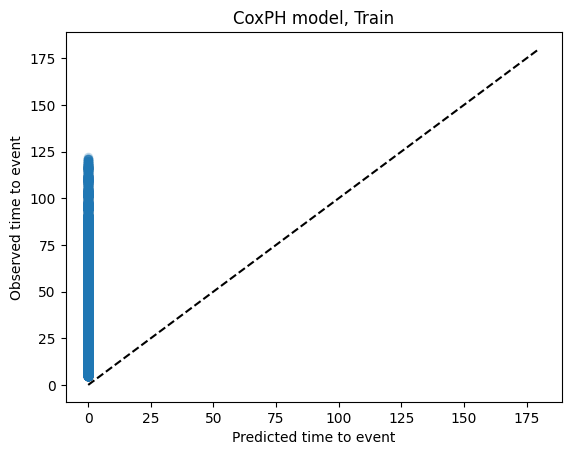

In [60]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('CoxPH model, Train')
plt.show()

## Test

In [61]:
# concordance index
cindex_test = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], coxph_all.predict(X_test))
print('C-index test: {:.3f}'.format(cindex_test[0]))

C-index test: 0.618


In [62]:
# get integrated brier score
cph_surv_prob = np.row_stack([fn(va_times) for fn in coxph_all.predict_survival_function(X_test)])

# brier score
ibs = integrated_brier_score(y_train, y_test, cph_surv_prob, va_times)
print('IBS: {:.3f}'.format(ibs))

IBS: 0.359


In [63]:
def get_mean_time(X, model, t0=0, tn=100):
    """Get mean time to event for a given time interval."""
    delta = np.linspace(t0, tn, 1000)
    surv_probas = np.row_stack([fn(delta) for fn in model.predict_survival_function(X)])

    # for each row, compute the area under the curve
    mean_time = np.array([simpson(y=y, x=delta) for y in surv_probas])
    return(mean_time)

def get_observed(X, y):
    # get observed time
    yobs = y[y['Status']]['Survival_in_days']

    # get observed rows
    Xobs = X[y['Status']]

    return Xobs, yobs

# predict mean time
Xobs, yobs = get_observed(X_test, y_test)
mean_time = get_mean_time(Xobs, coxph_all, t0=0, tn=120)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 45.220
MAPE: 1.000


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


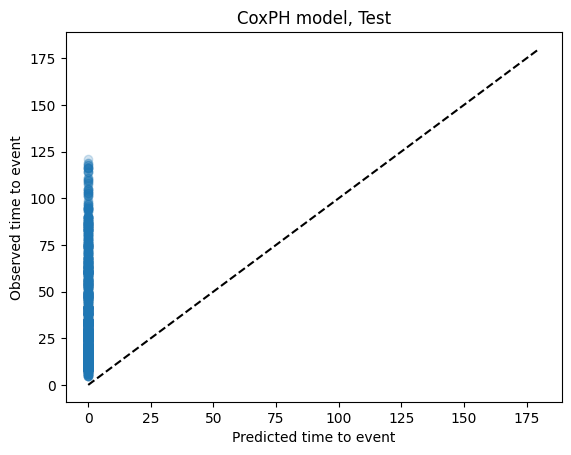

In [64]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('CoxPH model, Test')
plt.show()

### Particular

/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


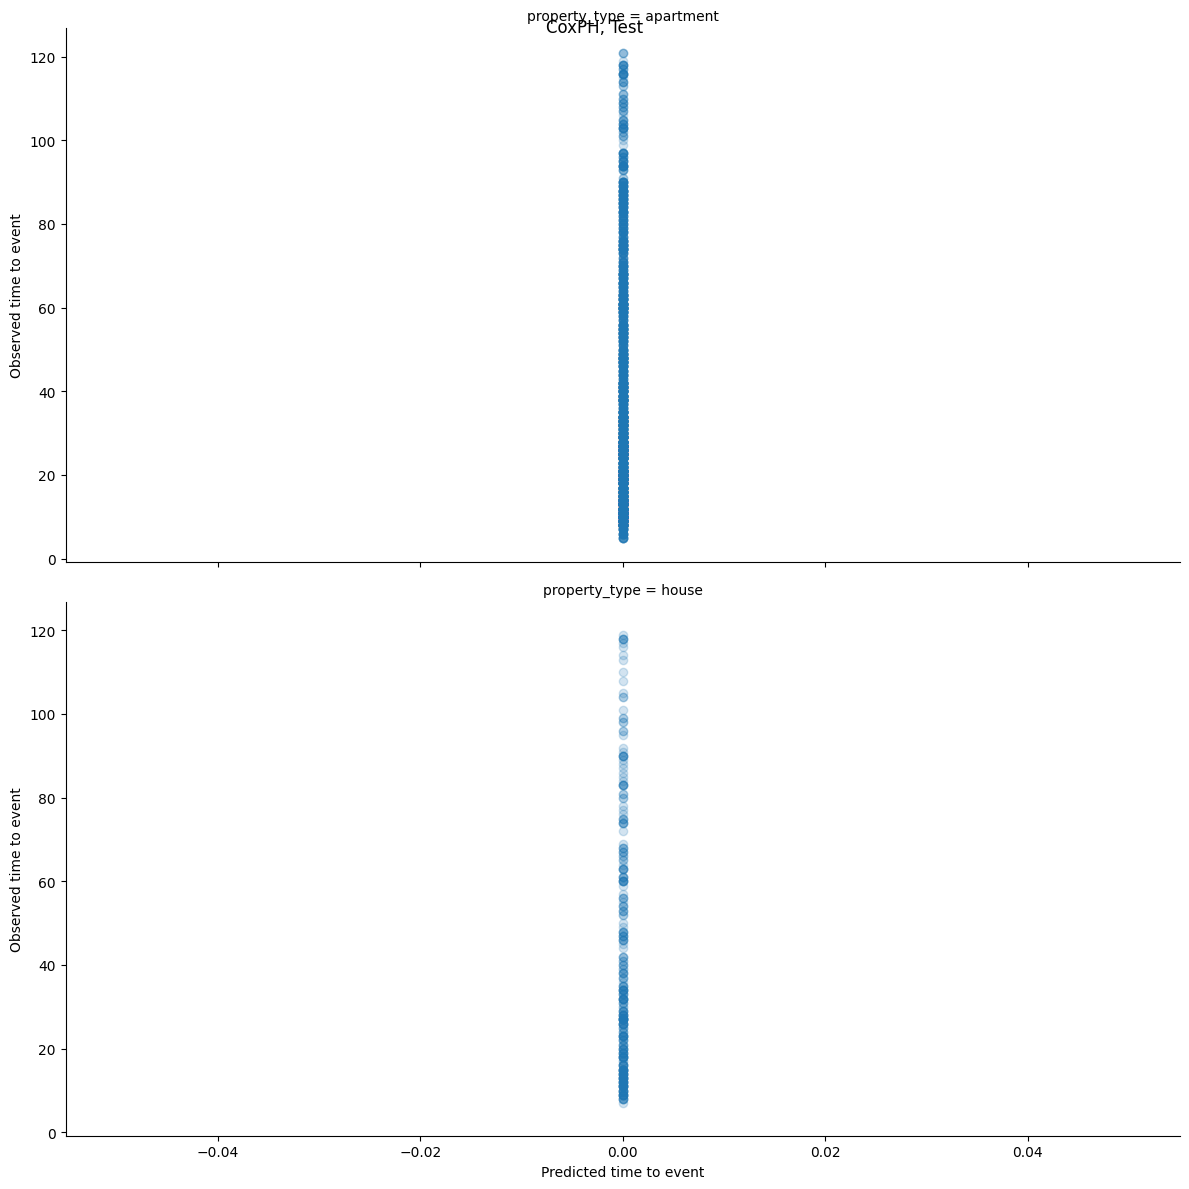

In [69]:
df_pred = (
    pd.DataFrame(X_test, columns=colnames_x_numeric)
    .assign(
        predicted_time=get_mean_time(X_test, coxph_all, t0=0, tn=10),
        risk_score=coxph_all.predict(X_test),
        observed_time=y_test['Survival_in_days'],
        event=y_test['Status']
    )
    .rename(columns={
        'listing_type=for-sale': 'listing_type',
        'property_type=house': 'property_type',
    })
    .assign(
        # listing_type=lambda x: np.where(x['listing_type'] == 1, 'for-sale', 'for-rent'),
        property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
    )
)

# plot a regplot observed vs predicted, facet grid listing_type and property_type

g = sns.FacetGrid(df_pred, row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('CoxPH, Test')
plt.show()

In [71]:
# get metrics
table_pred = (
    df_pred
    .groupby(['property_type'])
    .apply(get_metrics)
    .assign(type_info=TYPE_INFO)
)

# save
# os.makedirs('../../results/vanillas/', exist_ok=True)
# table_pred.to_csv('../../results/vanillas/coxph_all_data.csv', index=True)
table_pred
    

,rmse,mape,cindex,type_info
property_type,,,,
apartment,44.758050,1.0,0.614030,ALL_DATA
house,48.517463,1.0,0.642693,ALL_DATA


# IPCRidge

## Fit

In [72]:
aft_fit = IPCRidge(alpha=0.5)
aft_fit.fit(X_train, y_train)

IPCRidge(alpha=0.5)

In [73]:
# look params
pd.Series(aft_fit.coef_, index=colnames_x_numeric).sort_values()

woe_marketplace                     -0.157957
surface_total                       -0.120324
prediction_price_per_square_meter   -0.111116
green_index                         -0.045058
woe_id_sepomex                      -0.042825
woe_seller                          -0.033446
relative_cost_of_living             -0.026955
is_new_property_prob                -0.010616
num_bathrooms                        0.007307
num_parking_lots                     0.025532
days_active                          0.039718
diff_first_prediction                0.047780
pets_allowed                         0.051562
has_maintenance                      0.070830
is_exterior                          0.091369
page_on_marketplace                  0.110072
total_cost_of_living                 0.115843
first_price                          0.160983
longitude                            0.166876
cosine_tmonth                        0.181624
property_type=house                  0.184043
latitude                          

## Train

In [74]:
# r2
aft_fit.score(X_train, y_train)

0.5268948407176439

In [75]:
# get mape & mse
Xobs, yobs = get_observed(X_train, y_train)
mean_time = aft_fit.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 23.969
MAPE: 0.846


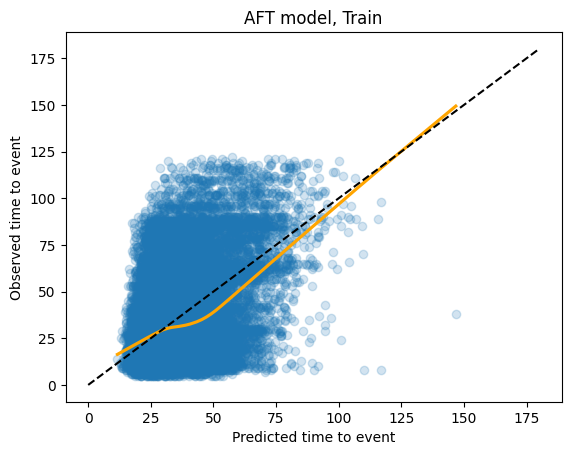

In [76]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('AFT model, Train')
plt.show()

## Test

In [77]:
# r2
aft_fit.score(X_test, y_test)

0.5318968007785178

In [78]:
# get mape & mse
Xobs, yobs = get_observed(X_test, y_test)
mean_time = aft_fit.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 23.480
MAPE: 0.793


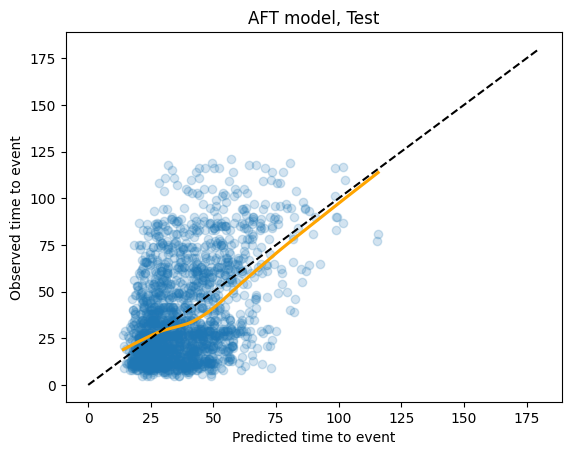

In [79]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('AFT model, Test')
plt.show()

### Particular

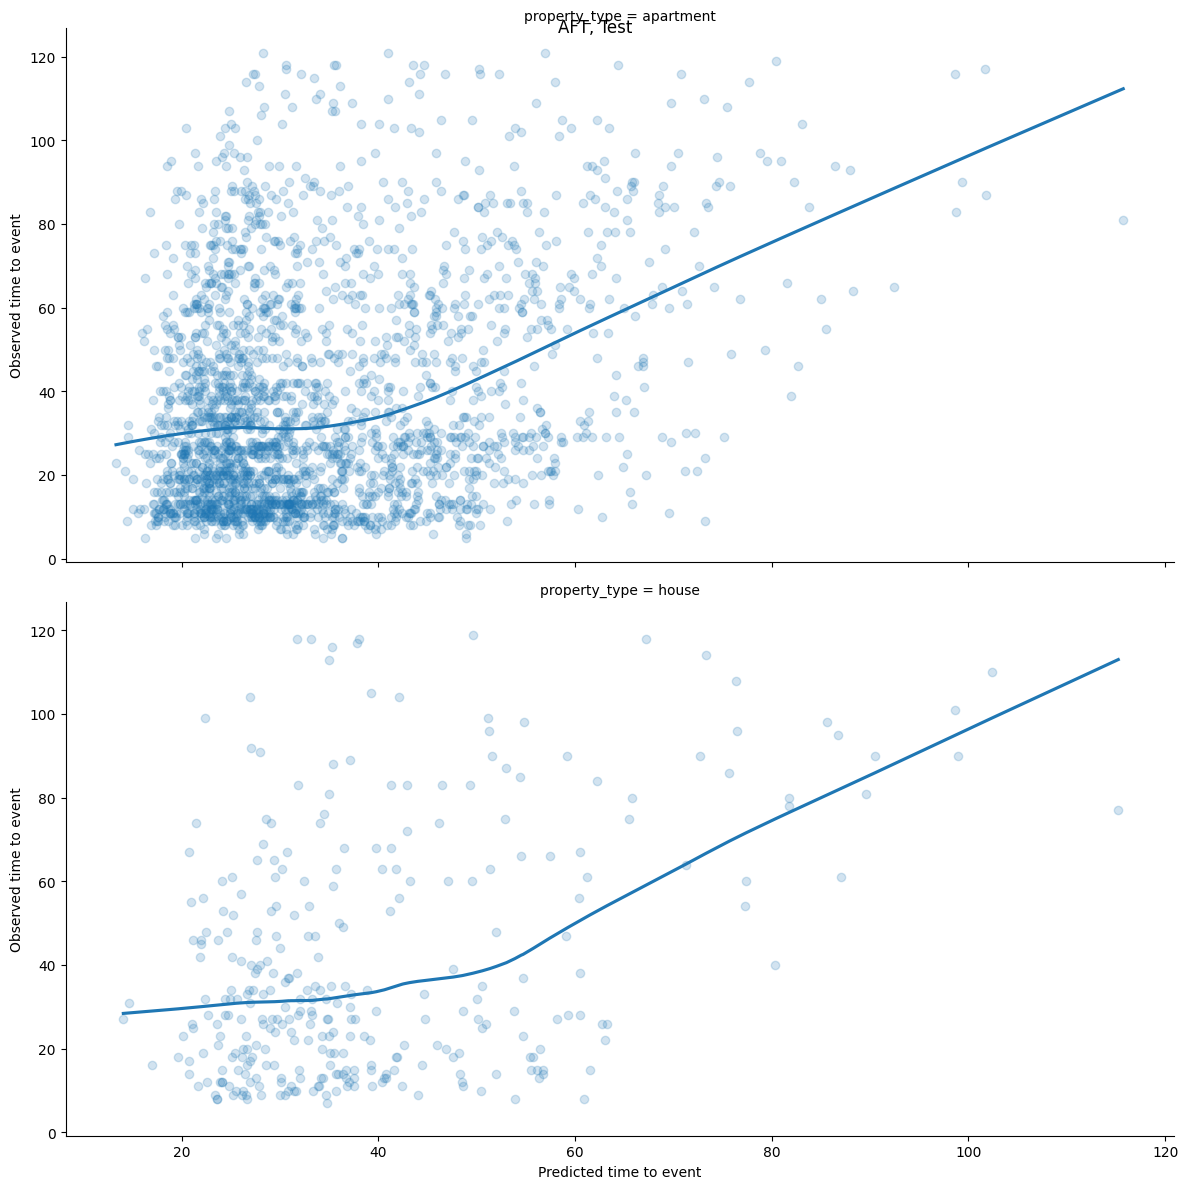

In [80]:
df_pred = (
    pd.DataFrame(X_test, columns=colnames_x_numeric)
    .assign(
        predicted_time=aft_fit.predict(X_test),
        risk_score=lambda x: - x['predicted_time'],
        observed_time=y_test['Survival_in_days'],
        event=y_test['Status']
    )
    .rename(columns={
        'property_type=house': 'property_type',
    })
    .assign(
        property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
    )
)

# plot a regplot observed vs predicted, facet grid listing_type and property_type

g = sns.FacetGrid(df_pred, row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('AFT, Test')
plt.show()

In [82]:
# get all
table_pred = (
    df_pred
    .groupby(['property_type'])
    .apply(get_metrics)
    .assign(type_info=TYPE_INFO)
)

# save
# os.makedirs('../../results/vanillas/', exist_ok=True)
# table_pred.to_csv('../../results/vanillas/aft_all_data.csv', index=True)
table_pred
    

,rmse,mape,cindex,type_info
property_type,,,,
apartment,23.332316,0.784249,0.530657,ALL_DATA
house,24.550850,0.857417,0.539116,ALL_DATA


# Gradient Boosting

## Fit

In [83]:
gbst_ipcw = GradientBoostingSurvivalAnalysis(
    loss='ipcwls',
    n_estimators=1000,
    learning_rate=0.1,
    random_state=42
)
gbst_ipcw.fit(X_train, y_train)

GradientBoostingSurvivalAnalysis(loss='ipcwls', n_estimators=1000,
                                 random_state=42)

## Train

In [84]:
# get mape & mse
Xobs, yobs = get_observed(X_train, y_train)
mean_time = gbst_ipcw.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 20.260
MAPE: 0.581


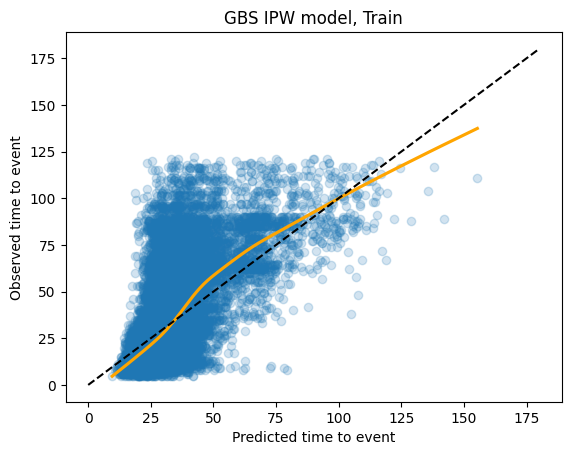

In [85]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('GBS IPW model, Train')
plt.show()

### Test

In [86]:
# get mape & mse
Xobs, yobs = get_observed(X_test, y_test)
mean_time = gbst_ipcw.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 22.071
MAPE: 0.643


In [87]:
# get r2 
gbst_ipcw.score(X_test, y_test)

0.6076544110938783

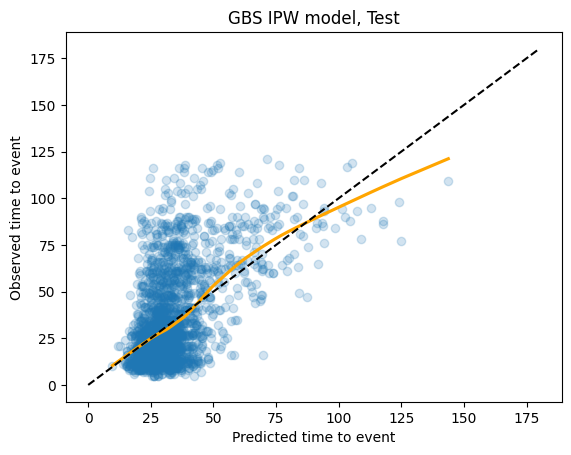

In [88]:
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('GBS IPW model, Test')
plt.show()

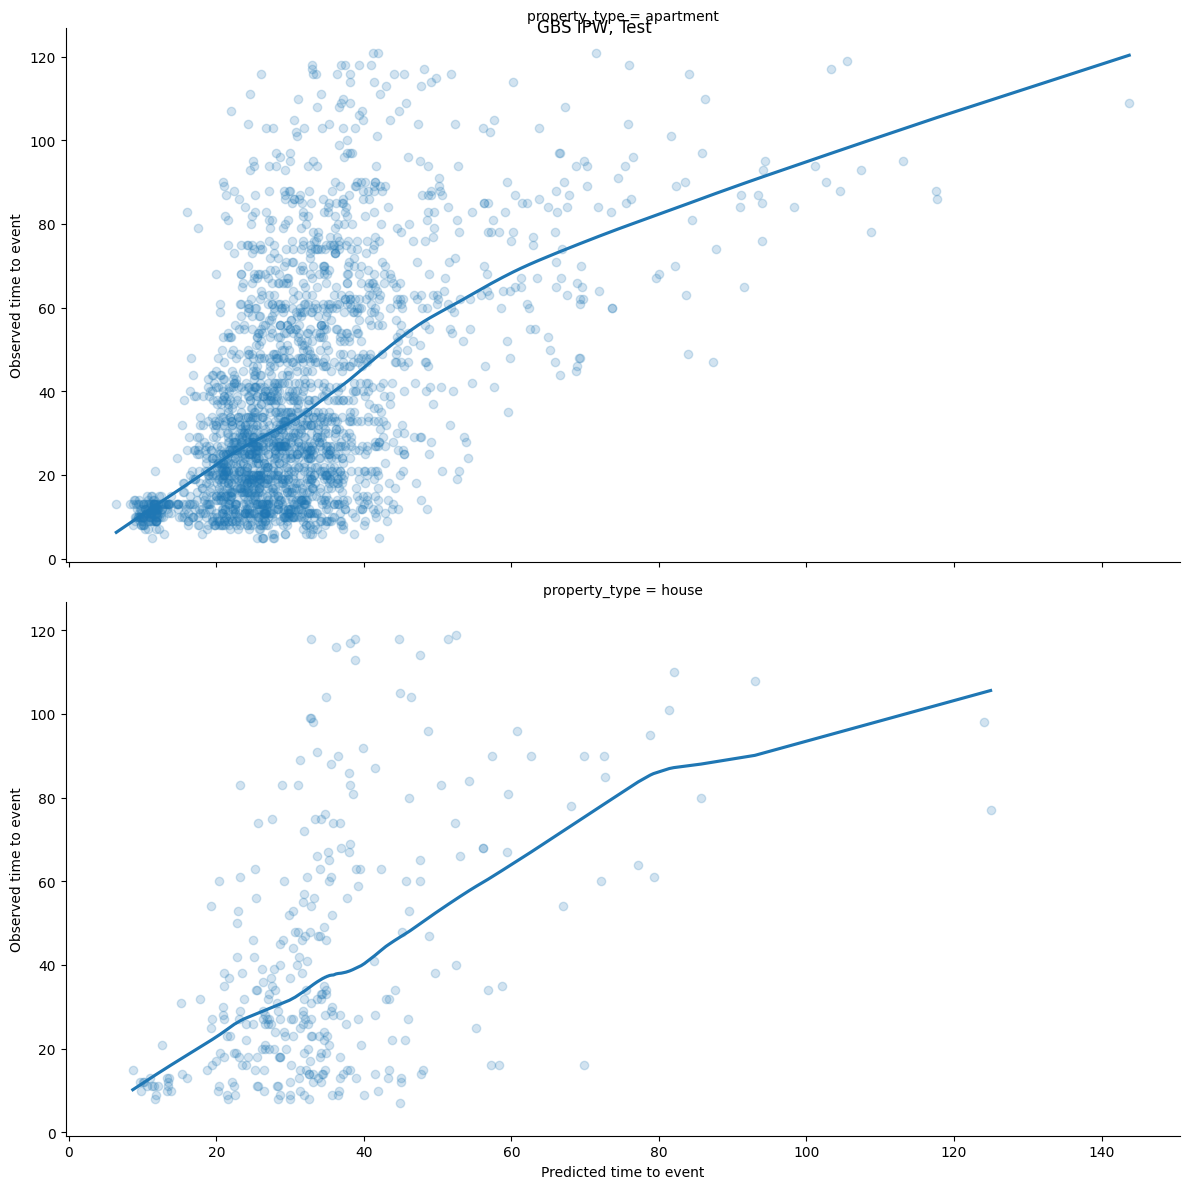

In [90]:
df_pred = (
    pd.DataFrame(X_test, columns=colnames_x_numeric)
    .assign(
        predicted_time=gbst_ipcw.predict(X_test),
        risk_score=lambda x: - x['predicted_time'],
        observed_time=y_test['Survival_in_days'],
        event=y_test['Status']
    )
    .rename(columns={
        'property_type=house': 'property_type',
    })
    .assign(
        property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
    )
)

# plot a regplot observed vs predicted, facet grid listing_type and property_type

g = sns.FacetGrid(df_pred, row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('GBS IPW, Test')
plt.show()

In [91]:
# get all
table_pred = (
    df_pred
    .groupby(['property_type'])
    .apply(get_metrics)
    .assign(type_info=TYPE_INFO)
)

# save
# os.makedirs('../../results/vanillas/', exist_ok=True)
# table_pred.to_csv('../../results/vanillas/gbs_ipw_all_data.csv', index=True)
table_pred
    

,rmse,mape,cindex,type_info
property_type,,,,
apartment,21.722560,0.630558,0.610514,ALL_DATA
house,24.507613,0.734548,0.583769,ALL_DATA


# XGBSE: Debaised BCE

## Fit

In [92]:
from xgbse import XGBSEDebiasedBCE

In [93]:
# get valiadtion data
X_train_bis, X_val, y_train_bis, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [95]:
xgb_debiased = XGBSEDebiasedBCE()
xgb_debiased.fit(
    X=X_train_bis, 
    y=y_train_bis, 
    validation_data=(X_val, y_val), 
    early_stopping_rounds=10, 
    verbose_eval=50,
    time_bins=np.arange(1, 120, 1)
    )

[0]	validation-aft-nloglik:11.61449


[50]	validation-aft-nloglik:3.64180
[100]	validation-aft-nloglik:3.56906
[150]	validation-aft-nloglik:3.56554
[175]	validation-aft-nloglik:3.56510


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/_debiased_bce.py:286: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/_debiased_bce.py:286: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/_debiased_bce.py:286: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/_debiased_bce.py:286: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/_debiased_bce.py:286: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


XGBSEDebiasedBCE(lr_params={'C': 0.001, 'max_iter': 500},
                 xgb_params={'aft_loss_distribution': 'normal',
                             'aft_loss_distribution_scale': 1,
                             'booster': 'dart', 'colsample_bynode': 0.5,
                             'eval_metric': 'aft-nloglik',
                             'learning_rate': 0.05, 'max_depth': 8,
                             'min_child_weight': 50,
                             'objective': 'survival:aft', 'subsample': 0.5,
                             'tree_method': 'hist'})

## Train

In [96]:
# see predictions
Xobs, yobs = get_observed(X_train, y_train)

# predict
df_mean_km = xgb_debiased.predict(Xobs)

RMSE: 25.401
MAPE: 1.135


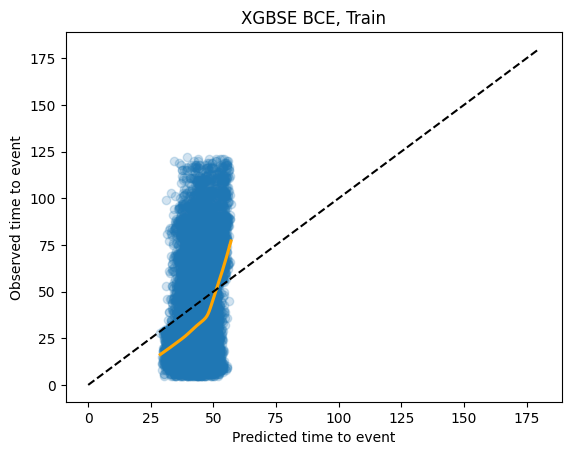

In [97]:
def get_xgbse_mean_time(df):
    """Get mean time to event for a given time interval."""
    # get linespace from names of columns
    delta = df.columns.astype(int).to_numpy()
    # get survival probabilities as the values of the dataframe
    surv_probas = df.values

    # for each row, compute the area under the curve
    mean_time = np.array([simpson(y=y, x=delta) for y in surv_probas])

    return(mean_time)

# predict mean time
mean_time = get_xgbse_mean_time(df_mean_km)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))


#### plot ####
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('XGBSE BCE, Train')
plt.show()

## Test

RMSE: 25.411
MAPE: 1.088


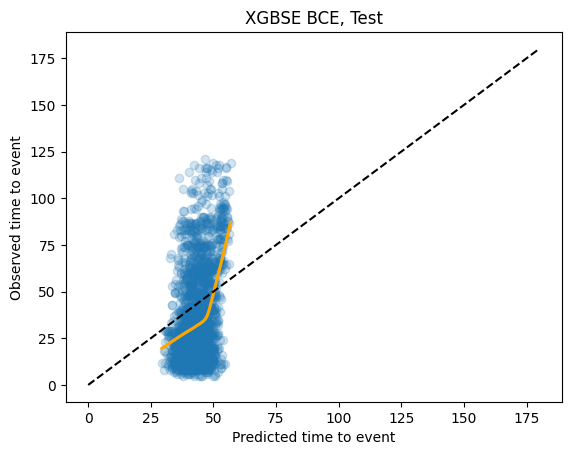

In [98]:
# see predictions
Xobs, yobs = get_observed(X_test, y_test)

# predict
df_mean_km = xgb_debiased.predict(Xobs)

# predict mean time
mean_time = get_xgbse_mean_time(df_mean_km)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))


#### plot ####
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('XGBSE BCE, Test')
plt.show()

### Particularm

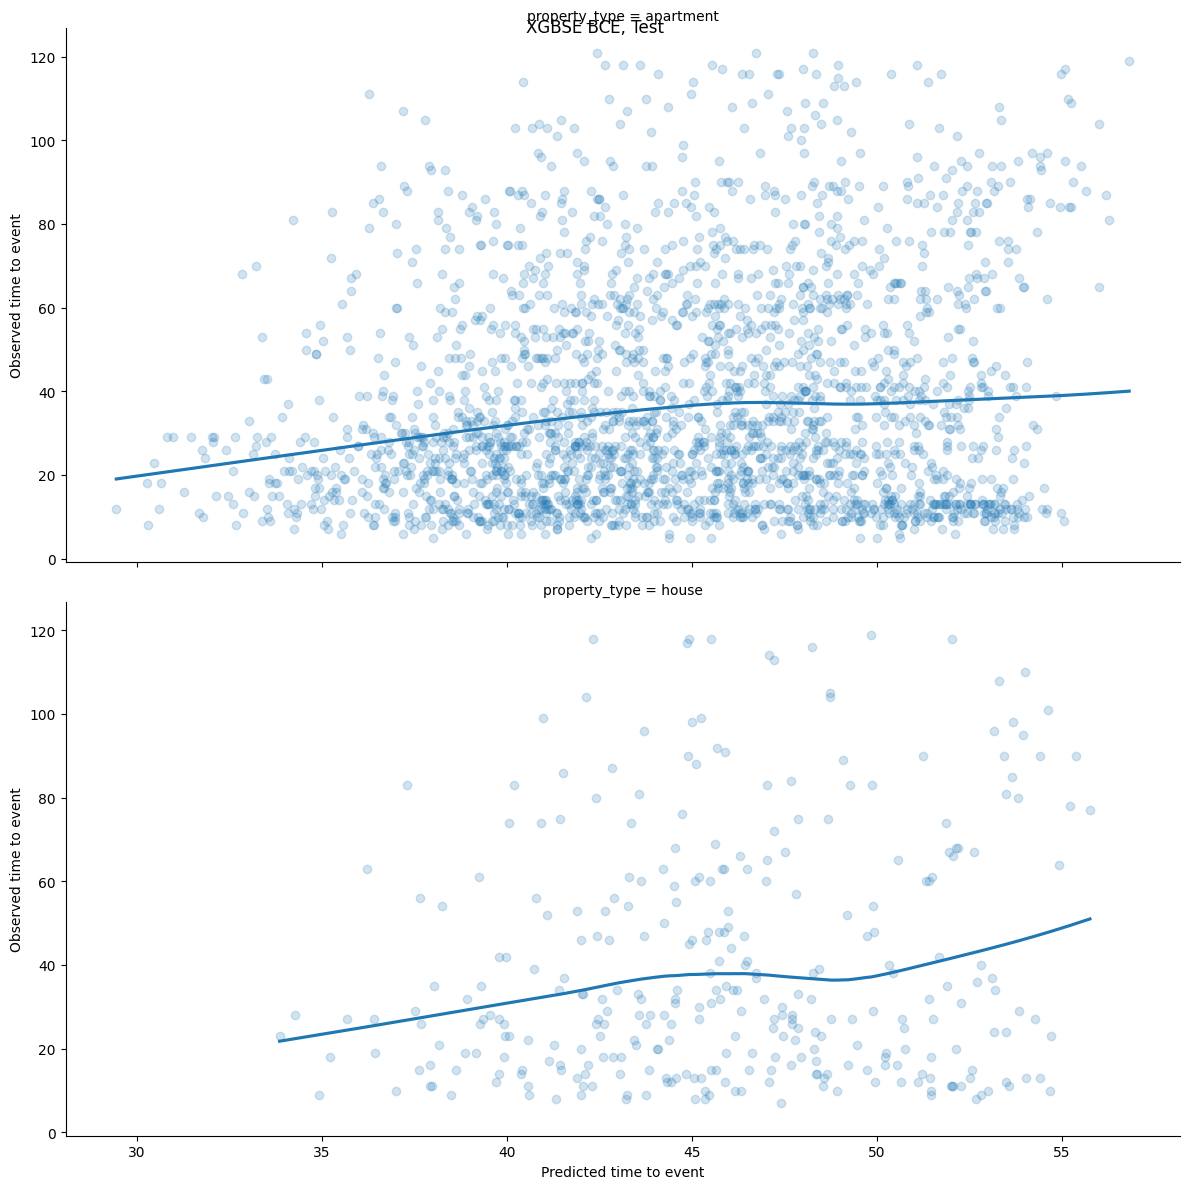

In [100]:
df_pred = (
    pd.DataFrame(X_test, columns=colnames_x_numeric)
    .assign(
        predicted_time=xgb_debiased.predict(X_test).pipe(get_xgbse_mean_time),
        risk_score=lambda x: - x['predicted_time'],
        observed_time=y_test['Survival_in_days'],
        event=y_test['Status']
    )
    .rename(columns={
        'property_type=house': 'property_type',
    })
    .assign(
        property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
    )
)

# plot a regplot observed vs predicted, facet grid listing_type and property_type

g = sns.FacetGrid(df_pred, row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('XGBSE BCE, Test')
plt.show()

In [101]:
# get all
table_pred = (
    df_pred
    .groupby(['property_type'])
    .apply(get_metrics)
    .assign(type_info=TYPE_INFO)
)

# save
# os.makedirs('../../results/vanillas/', exist_ok=True)
# table_pred.to_csv('../../results/vanillas/xgbse_bce_all_data.csv', index=True)
table_pred
    

,rmse,mape,cindex,type_info
property_type,,,,
apartment,25.111858,1.086473,0.645527,ALL_DATA
house,27.533655,1.095278,0.639524,ALL_DATA


# XGBSE: Weibull

## Fit

In [102]:
from xgbse import XGBSEStackedWeibull


In [103]:
# get valiadtion data
X_train_bis, X_val, y_train_bis, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [104]:
xgb_weibull = XGBSEStackedWeibull()
xgb_weibull.fit(
    X=X_train_bis, 
    y=y_train_bis, 
    validation_data=(X_val, y_val), 
    early_stopping_rounds=10, 
    verbose_eval=50,
    time_bins=np.arange(1, 171, 1)
    )

[0]	validation-aft-nloglik:11.61449


[50]	validation-aft-nloglik:3.64180
[100]	validation-aft-nloglik:3.56906
[150]	validation-aft-nloglik:3.56554
[175]	validation-aft-nloglik:3.56510


XGBSEStackedWeibull(weibull_params={},
                    xgb_params={'aft_loss_distribution': 'normal',
                                'aft_loss_distribution_scale': 1,
                                'booster': 'dart', 'colsample_bynode': 0.5,
                                'eval_metric': 'aft-nloglik',
                                'learning_rate': 0.05, 'max_depth': 8,
                                'min_child_weight': 50,
                                'objective': 'survival:aft', 'subsample': 0.5,
                                'tree_method': 'hist'})

## Train

In [105]:
# see predictions
Xobs, yobs = get_observed(X_train, y_train)

# predict
df_mean_km = xgb_weibull.predict(Xobs)

In [106]:
df_mean_km

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,161.0,162.0,163.0,164.0,165.0,166.0,167.0,168.0,169.0,170.0
0,0.995373,0.986274,0.974161,0.959648,0.943140,0.924947,0.905322,0.884482,0.862620,0.839907,...,9.200344e-07,8.028468e-07,7.002461e-07,6.104621e-07,5.319334e-07,4.632836e-07,4.033000e-07,3.509147e-07,3.051881e-07,2.652937e-07
1,0.993862,0.981976,0.966307,0.947689,0.926680,0.903709,0.879127,0.853236,0.826303,0.798563,...,3.075668e-08,2.599552e-08,2.195854e-08,1.853766e-08,1.564061e-08,1.318865e-08,1.111464e-08,9.361378e-09,7.880141e-09,6.629469e-09
2,0.998982,0.996825,0.993831,0.990124,0.985785,0.980871,0.975428,0.969497,0.963110,0.956296,...,1.377745e-02,1.318717e-02,1.261999e-02,1.207510e-02,1.155175e-02,1.104916e-02,1.056662e-02,1.010342e-02,9.658858e-03,9.232280e-03
3,0.995257,0.985941,0.973549,0.958712,0.941847,0.923272,0.903249,0.882000,0.859723,0.836595,...,7.018866e-07,6.109229e-07,5.314859e-07,4.621506e-07,4.016635e-07,3.489224e-07,3.029586e-07,2.629218e-07,2.280652e-07,1.977339e-07
4,0.997544,0.992553,0.985781,0.977541,0.968034,0.957412,0.945798,0.933296,0.919998,0.905985,...,2.021822e-04,1.857283e-04,1.705593e-04,1.565798e-04,1.437007e-04,1.318395e-04,1.209194e-04,1.108690e-04,1.016223e-04,9.311770e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17961,0.997374,0.992056,0.984853,0.976101,0.966018,0.954766,0.942478,0.929266,0.915229,0.900457,...,1.284754e-04,1.175065e-04,1.074385e-04,9.820059e-05,8.972741e-05,8.195836e-05,7.483741e-05,6.831279e-05,6.233665e-05,5.686477e-05
17962,0.995574,0.986850,0.975219,0.961266,0.945377,0.927847,0.908915,0.888789,0.867650,0.845662,...,1.471928e-06,1.290159e-06,1.130304e-06,9.897911e-07,8.663402e-07,7.579325e-07,6.627814e-07,5.793064e-07,5.061101e-07,4.419579e-07
17963,0.998539,0.995495,0.991306,0.986156,0.980159,0.973402,0.965954,0.957872,0.949206,0.940002,...,3.416060e-03,3.225232e-03,3.044386e-03,2.873042e-03,2.710741e-03,2.557042e-03,2.411526e-03,2.273791e-03,2.143451e-03,2.020140e-03
17964,0.996765,0.990284,0.981558,0.971006,0.958902,0.945451,0.930820,0.915154,0.898578,0.881206,...,2.665608e-05,2.401592e-05,2.162901e-05,1.947191e-05,1.752329e-05,1.576371e-05,1.417546e-05,1.274243e-05,1.144997e-05,1.028474e-05


RMSE: 25.771
MAPE: 0.905


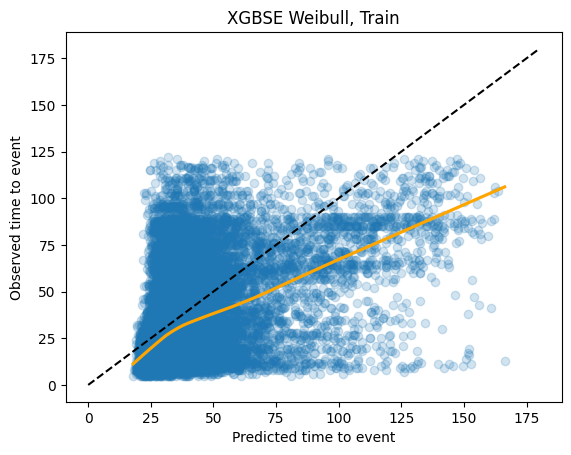

In [107]:
def get_xgbse_mean_time(df):
    """Get mean time to event for a given time interval."""
    # get linespace from names of columns
    delta = df.columns.astype(int).to_numpy()
    # get survival probabilities as the values of the dataframe
    surv_probas = df.values

    # for each row, compute the area under the curve
    mean_time = np.array([simpson(y=y, x=delta) for y in surv_probas])

    return(mean_time)

# predict mean time
mean_time = get_xgbse_mean_time(df_mean_km)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))


#### plot ####
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('XGBSE Weibull, Train')
plt.show()

## Test

RMSE: 27.661
MAPE: 0.957


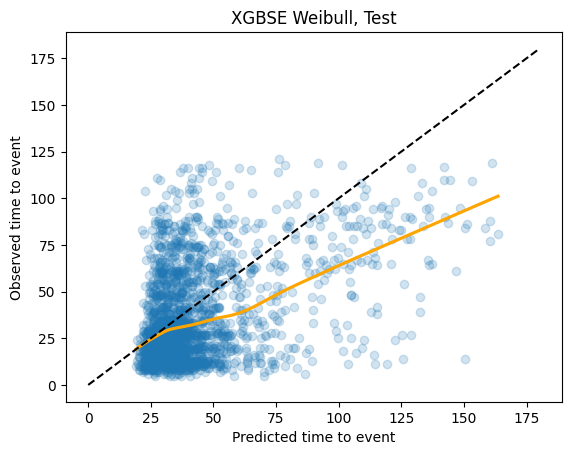

In [108]:
# see predictions
Xobs, yobs = get_observed(X_test, y_test)

# predict
df_mean_km = xgb_weibull.predict(Xobs)

# predict mean time
mean_time = get_xgbse_mean_time(df_mean_km)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))


#### plot ####
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('XGBSE Weibull, Test')
plt.show()

### Particular

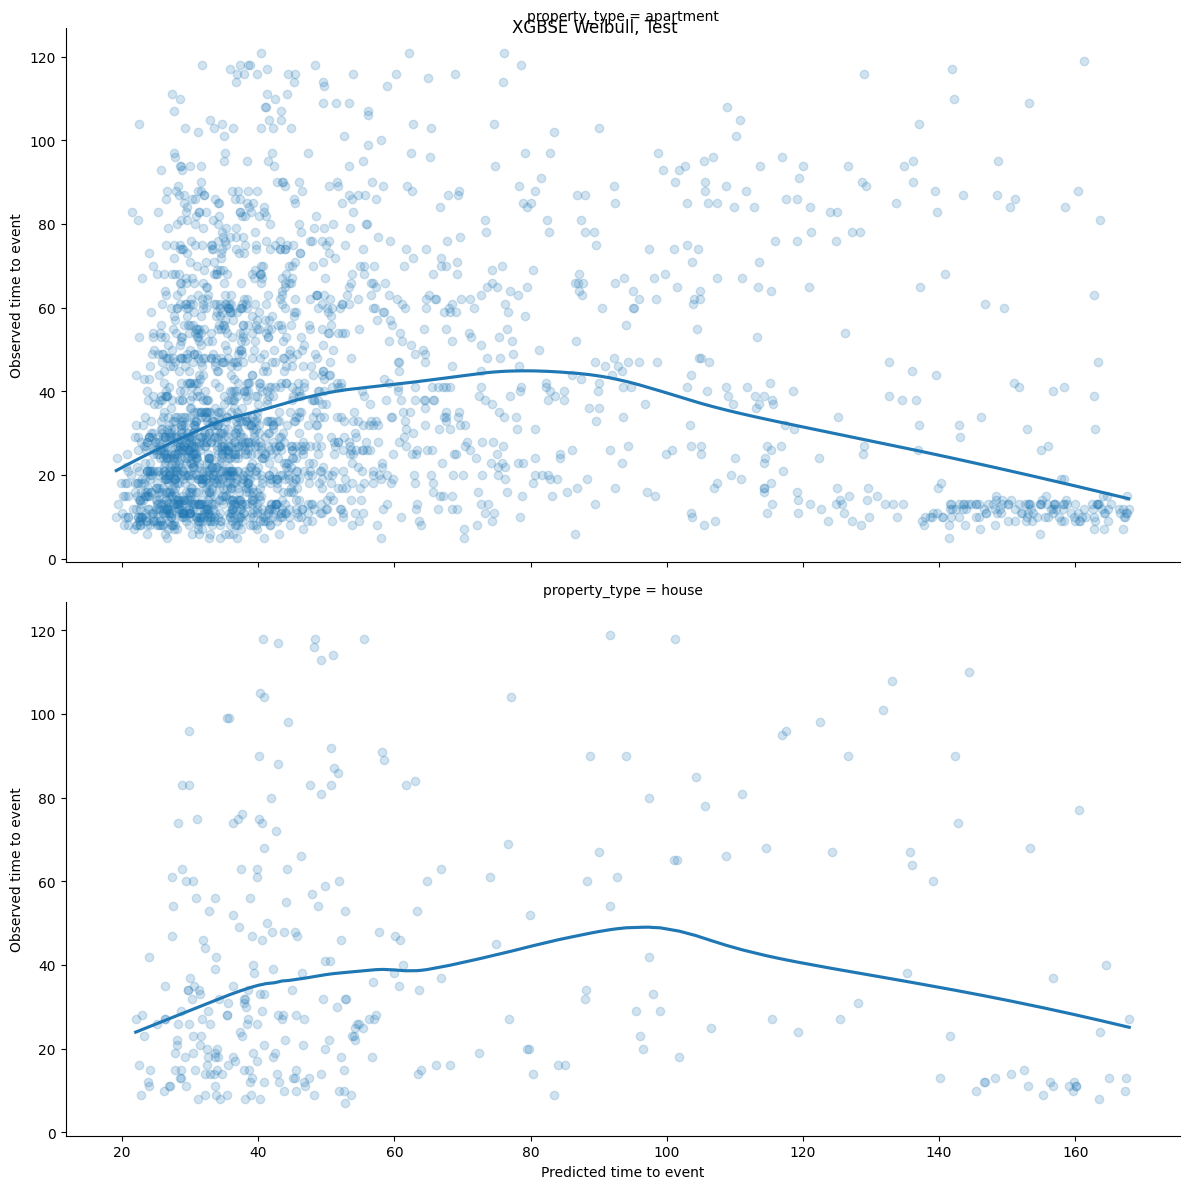

In [110]:
df_pred = (
    pd.DataFrame(X_test, columns=colnames_x_numeric)
    .assign(
        predicted_time=xgb_weibull.predict(X_test).pipe(get_xgbse_mean_time),
        risk_score=lambda x: - x['predicted_time'],
        observed_time=y_test['Survival_in_days'],
        event=y_test['Status']
    )
    .rename(columns={
        'property_type=house': 'property_type',
    })
    .assign(
        property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
    )
)

# plot a regplot observed vs predicted, facet grid listing_type and property_type

g = sns.FacetGrid(df_pred,row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('XGBSE Weibull, Test')
plt.show()

In [111]:
# get all
table_pred = (
    df_pred
    .groupby([ 'property_type'])
    .apply(get_metrics)
    .assign(type_info=TYPE_INFO)
)

# save
# os.makedirs('../../results/vanillas/', exist_ok=True)
# table_pred.to_csv('../../results/vanillas/xgbse_weibull_all_data.csv', index=True)
table_pred
    

,rmse,mape,cindex,type_info
property_type,,,,
apartment,27.271662,0.943880,0.659840,ALL_DATA
house,30.400353,1.055253,0.664843,ALL_DATA


# Naive Approach: Dont Use Censorship

## Fit

In [112]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=1000, 
    learning_rate=0.1,
    random_state=42
)
X_train_obs = X_train[y_train['Status']]
y_train_obs = y_train[y_train['Status']]['Survival_in_days']
gbr.fit(X_train_obs, y_train_obs)

GradientBoostingRegressor(n_estimators=1000, random_state=42)

## Train

In [113]:
# concordance index
cindex_train = concordance_index_censored(y_train['Status'], y_train['Survival_in_days'], - gbr.predict(X_train))
print('C-index train: {:.3f}'.format(cindex_train[0]))

C-index train: 0.624


In [114]:
# get mape & mse
Xobs, yobs = get_observed(X_train, y_train)
mean_time = gbr.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time[:10] - yobs[:10])**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time[:10] - yobs[:10]) / yobs[:10]))
print('MAPE: {:.3f}'.format(mape))

RMSE: 7.652
MAPE: 0.228


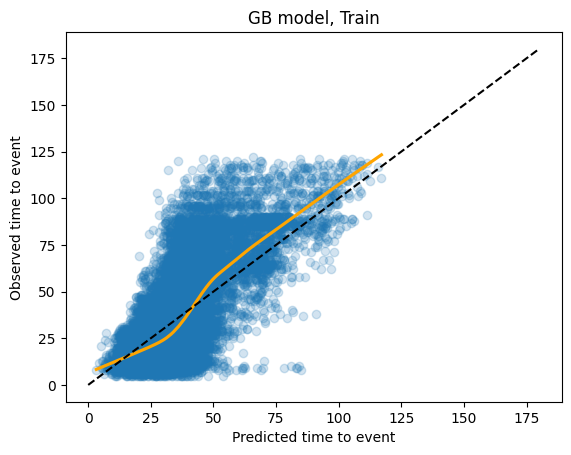

In [115]:
### plot ####
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('GB model, Train')
plt.show()

## Test

In [116]:
# concordance index
cindex_test = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], gbr.predict(X_test))
print('C-index test: {:.3f}'.format(cindex_test[0]))

C-index test: 0.438


RMSE: 21.202
MAPE: 0.707


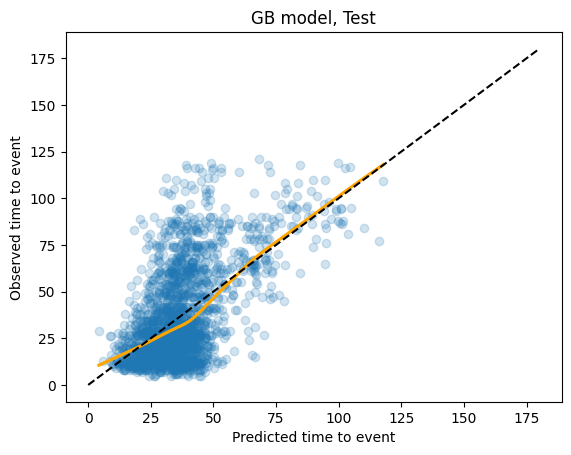

In [117]:
# get mape & mse
Xobs, yobs = get_observed(X_test, y_test)
mean_time = gbr.predict(Xobs)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

#### plot ####
# look observed vs predicted
plt.scatter(mean_time, yobs, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange', lowess=True)
# add lines
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Predicted time to event')
plt.ylabel('Observed time to event')
plt.title('GB model, Test')
plt.show()

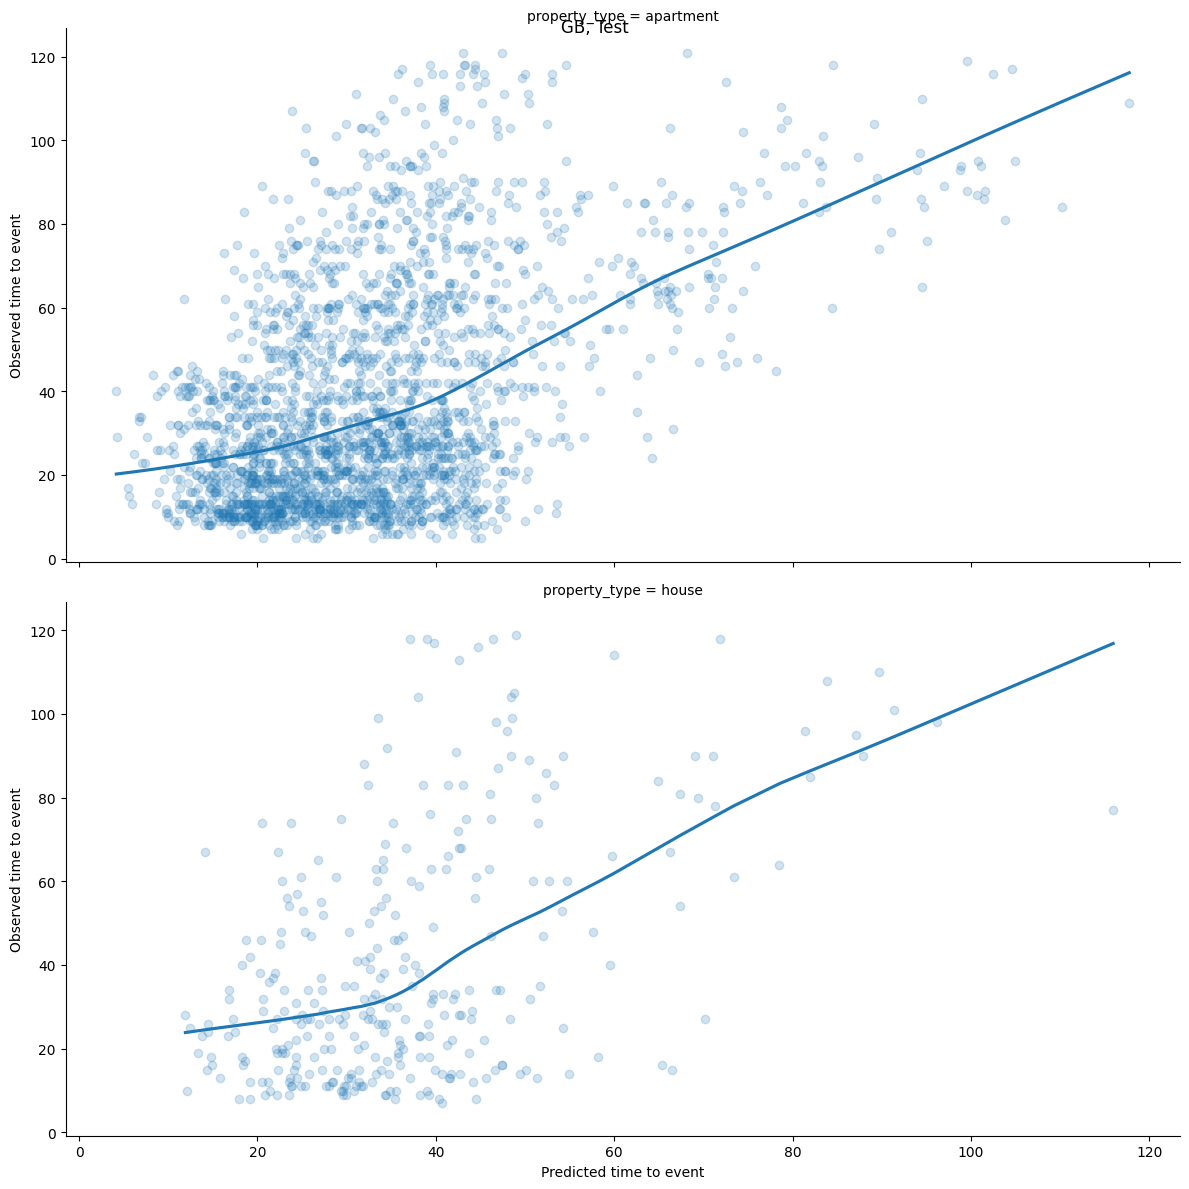

In [118]:
df_pred = (
    pd.DataFrame(X_test, columns=colnames_x_numeric)
    .assign(
        predicted_time=gbr.predict(X_test),
        risk_score=lambda x: - x['predicted_time'],
        observed_time=y_test['Survival_in_days'],
        event=y_test['Status']
    )
    .rename(columns={
        'property_type=house': 'property_type',
    })
    .assign(
        property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
    )
)

# plot a regplot observed vs predicted, facet grid listing_type and property_type

g = sns.FacetGrid(df_pred, row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('GB, Test')
plt.show()

In [119]:
# get all
table_pred = (
    df_pred
    .groupby([ 'property_type'])
    .apply(get_metrics)
    .assign(type_info=TYPE_INFO)
)

# save
# os.makedirs('../../results/vanillas/', exist_ok=True)
# table_pred.to_csv('../../results/vanillas/gb_all_data.csv', index=True)
table_pred
    

,rmse,mape,cindex,type_info
property_type,,,,
apartment,20.939008,0.698206,0.561207,ALL_DATA
house,23.064970,0.775179,0.561158,ALL_DATA
